# **1. Import Libraries**

In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime
import pandas as pd
import cv2
import os
import io

# **2. Load Data**

**2-1. Connect To Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2-2. Unzip Dataset**

In [3]:
# from zipfile import ZipFile

# with ZipFile('drive/MyDrive/brain_dataset.zip', 'r') as zipOb:
#   zipOb.extractall('drive/MyDrive/brain_tumor_dataset')

**2-3. Loading and Resizing**

In [4]:
labels = []

X_train = []
y_train = []
X_test = []
y_test = []


trainPath = 'drive/MyDrive/brain_tumor_dataset'+'/Training/'
testPath = 'drive/MyDrive/brain_tumor_dataset'+'/Testing/'


for folder in os.listdir(trainPath):
    labels.append(folder)


for i in labels:
    labelPath = os.path.join(trainPath,i)
    for j in os.listdir(labelPath):
        img = cv2.imread(os.path.join(labelPath,j))
        img = cv2.resize(img,(128, 128))
        X_train.append(img)
        y_train.append(i)


for i in labels:
    labelPath = os.path.join(testPath,i)
    for j in os.listdir(labelPath):
        img = cv2.imread(os.path.join(labelPath,j))
        img = cv2.resize(img,(128, 128))
        X_test.append(img)
        y_test.append(i)

**2-4. Converting Lists to NumPy Arrays**

In [5]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# rescaling
X_train=X_train/255.0
X_test=X_test/255.0

**2-5. Visualizing Random Samples from the Dataset**

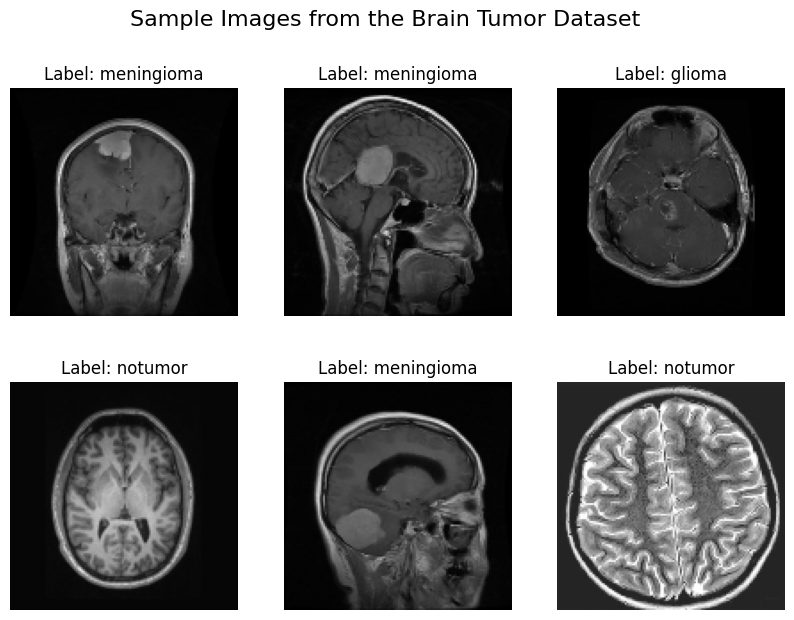

In [6]:
# Display sample images from the training set
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
fig.suptitle('Sample Images from the Brain Tumor Dataset', fontsize=16)

for i in range(2):
    for j in range(3):
        random_index = np.random.randint(0, len(X_train))
        axes[i, j].imshow(X_train[random_index])
        axes[i, j].set_title(f'Label: {y_train[random_index]}')
        axes[i, j].axis('off')

plt.show()

# **3. Data Preparation Pipeline: One-Hot Encoding, Splitting and Data Generation**

**3-1. One-Hot Encoding Labels**

In [7]:
# One Hot Encoding
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**3-2. Shuffling and Splitting Data**

In [8]:
# # Let's shuffle the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

**3-3. Checking Shapes of Training, Testing, and Validation Sets**

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(4855, 128, 128, 3) (4855, 4)
(1311, 128, 128, 3) (1311, 4)
(857, 128, 128, 3) (857, 4)


**3-4. Creating Training Data Generator**


*   **Zooming:** Zooming in and out can simulate variations in image resolution and focus.
*   **Horizontal and Vertical Flips:** Mirroring the images horizontally and vertically can help the model generalize better.
*   **Shearing:** Applying a small amount of shearing can simulate changes in the angle of the MRI scan.

In [10]:
train_datagen = ImageDataGenerator(
    fill_mode="nearest",
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)



train_datagenerator = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True
)

# **4. Network Architecture**

**4-1. VGG16 Architecture**
**(Fine tuning)**

In [11]:
import sys
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16

pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in pre_trained_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D



x = pre_trained_model.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(x)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(4, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.trainable = True

# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

# **5. Training**

**5-1. Early Stopping**

In [14]:
# from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

**5-2. Training VGG16**

In [15]:
history = model.fit(train_datagenerator, validation_data = (X_val,y_val), epochs =30, batch_size=32)

Epoch 1/30
137/137 [==============================] - 51s 249ms/step - loss: 1.3164 - accuracy: 0.3497 - val_loss: 1.5238 - val_accuracy: 0.3267
Epoch 2/30
137/137 [==============================] - 27s 198ms/step - loss: 0.9475 - accuracy: 0.5805 - val_loss: 0.7283 - val_accuracy: 0.6803
Epoch 3/30
137/137 [==============================] - 26s 188ms/step - loss: 0.8106 - accuracy: 0.6522 - val_loss: 0.8650 - val_accuracy: 0.5904
Epoch 4/30
137/137 [==============================] - 25s 181ms/step - loss: 0.7466 - accuracy: 0.6844 - val_loss: 0.7017 - val_accuracy: 0.6873
Epoch 5/30
137/137 [==============================] - 26s 189ms/step - loss: 0.6445 - accuracy: 0.7270 - val_loss: 0.5517 - val_accuracy: 0.7713
Epoch 6/30
137/137 [==============================] - 26s 193ms/step - loss: 0.6011 - accuracy: 0.7616 - val_loss: 0.5848 - val_accuracy: 0.7713
Epoch 7/30
137/137 [==============================] - 25s 185ms/step - loss: 0.5405 - accuracy: 0.8011 - val_loss: 0.6534 - val_ac

- VGG16 is loaded with pre-trained ImageNet weights.
- The base model's output is flattened, followed by a Dense layer with 512 units and ReLU activation.
- A Dropout layer with a dropout rate of 0.5 is added for regularization.
- The final layer is a Dense layer with 4 units (for 4 classes) and softmax activation.
- The model is compiled using the Adam optimizer with a learning rate of 0.001.
- Categorical crossentropy is used as the loss function, and accuracy is chosen as the evaluation metric.


# **6. Model Predictions**

**6-1. Calculating Accuracy of VGG16 Model**

In [16]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test,axis=1)
accuracy = np.sum(pred==y_test_new)/len(pred)
print(accuracy)

41/41 [==============================] - 5s 113ms/step
0.9405034324942791


 The model correctly predicted the class labels for approximately 95.65% of the samples in the test dataset.

# **7. Visualizing**

**7-1. Visualizing VGG16 Model Performance: Accuracy and Loss Over Epochs**

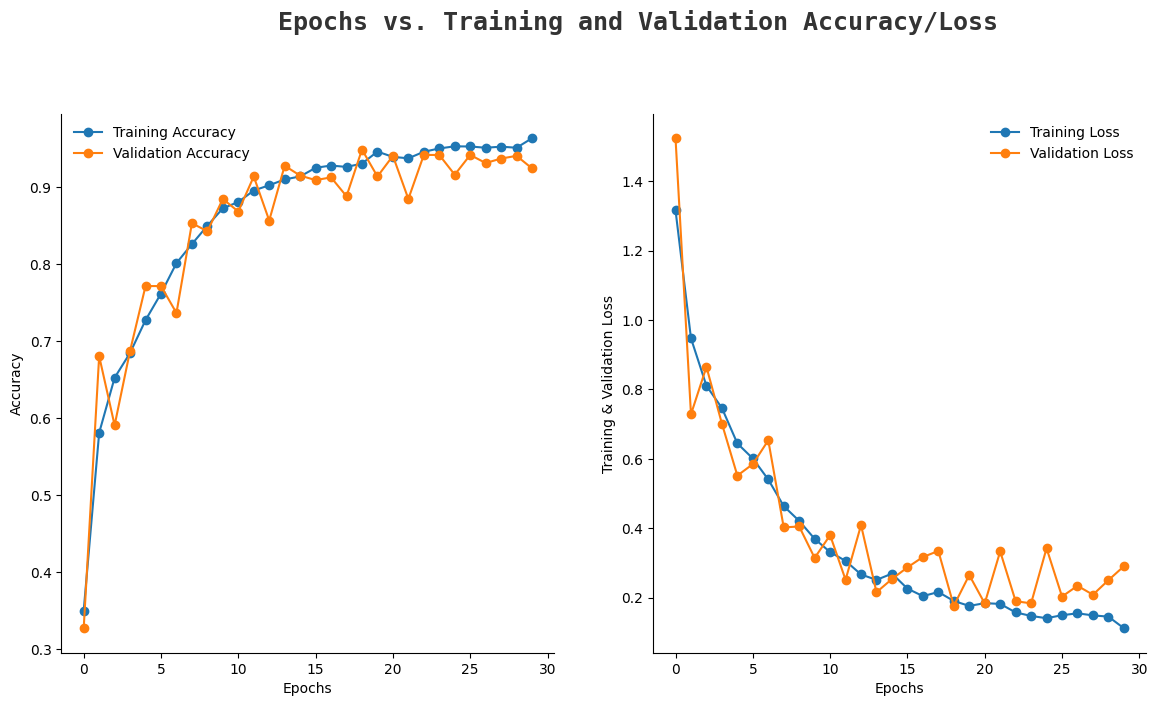

In [17]:
epochs = [i for i in range(30)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

- The training accuracy is gradually increasing, reaching a high value (95.38%) by the end of training.
- The training loss is decreasing, indicating that the model is learning from the training data.
- The validation accuracy shows improvement initially but experiences fluctuations in later epochs. It reaches a high value (93.47%) by the end of training.
- The validation loss also fluctuates.


41/41 [==============================] - 2s 41ms/step


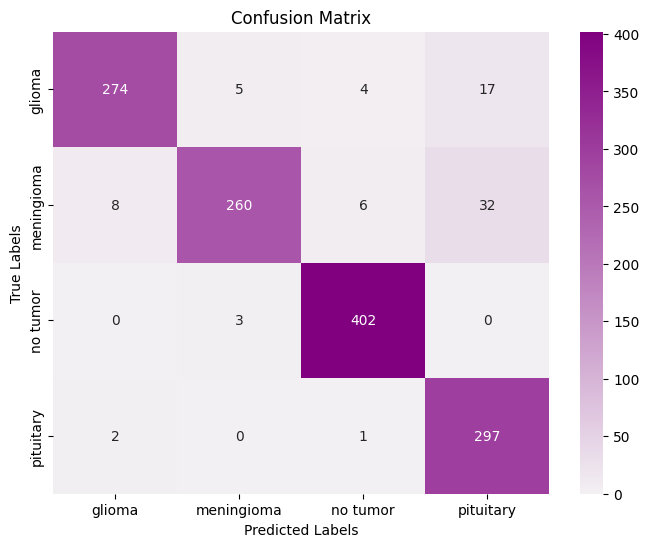

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and X_test, y_test are your test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get the true labels
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define a colormap
cmap = sns.light_palette("purple", as_cmap=True)

# Plot the confusion matrix with color
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap,
            xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
